## Diversity optimization

In [15]:
# required modules (under Anaconda use: > conda install -c conda-forge <package>)
if False: # (skip if already installed)
    !pip install lark-parser
    !pip install linear-tree
    !pip install pydot
    !pip install pydotplus
    # download and install SWI Prolog from https://www.swi-prolog.org/download/stable
    # be sure that the executable is added to the PATH

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# standard imports
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
import matplotlib.pyplot as plt
import pydotplus
from IPython.display import Image

# imported packages
from lineartree import LinearTreeClassifier

# local imports
sys.path.append('../src/') # local path
import reasonx
import dautils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Example on continuous only attributes

In [17]:
continuous_only = False

### Read dataframe

In [18]:
# read dataset
df = pd.read_csv('../data/adult_continuous.csv', na_values='?')
# remove unused columns
del df['fnlwgt']
del df['education-num']
# simplify dataframe
del df['marital-status']
del df['native-country']
del df['occupation']
del df['relationship']
# remove special characters in column names and values
df.columns = df.columns.str.replace("[-&()]", "", regex=True)
df = df.replace('[-&()]', '', regex=True)
# missing values imputation with mode (needed for Decision Trees)
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           48842 non-null  int64 
 1   workclass     48842 non-null  object
 2   education     48842 non-null  object
 3   race          48842 non-null  object
 4   sex           48842 non-null  object
 5   capitalgain   48842 non-null  int64 
 6   capitalloss   48842 non-null  int64 
 7   hoursperweek  48842 non-null  int64 
 8   class         48842 non-null  object
dtypes: int64(4), object(5)
memory usage: 3.4+ MB


In [19]:
df

,age,workclass,education,race,sex,capitalgain,capitalloss,hoursperweek,class
0,39,Stategov,Bachelors,White,Male,2174,0,40,<=50K
1,50,Selfempnotinc,Bachelors,White,Male,0,0,13,<=50K
2,38,Private,HSgrad,White,Male,0,0,40,<=50K
3,53,Private,11th,Black,Male,0,0,40,<=50K
4,28,Private,Bachelors,Black,Female,0,0,40,<=50K
...,...,...,...,...,...,...,...,...,...
48837,39,Private,Bachelors,White,Female,0,0,36,<=50K
48838,64,Private,HSgrad,Black,Male,0,0,40,<=50K
48839,38,Private,Bachelors,White,Male,0,0,50,<=50K
48840,44,Private,Bachelors,AsianPacIslander,Male,5455,0,40,<=50K


In [20]:
# nominal-ordinal-continuous partition of predictive attributes
nominal_atts = [] if continuous_only else ['race', 'sex', 'workclass']
ordinal_atts = [] if continuous_only else ['education']
continuous_atts = ['age', 'capitalgain', 'hoursperweek'] if continuous_only else ['age', 'capitalgain', 'capitalloss', 'hoursperweek']
# class attribute
target = 'class'
# predictive atts
pred_atts = nominal_atts + ordinal_atts + continuous_atts

In [21]:
# forcing encoding of ordinal attributes (consistent with the order) and class attribute (0=negatives, 1=positives)
decode = {
    'education': {
        1:'Preschool', 2:'1st4th', 3:'5th6th', 4:'7th8th', 5:'9th', 6:'10th', 7:'11th',
        8:'12th', 9:'HSgrad', 10:'Somecollege', 11:'Assocvoc', 12:'Assocacdm', 13:'Bachelors', 
        14:'Masters', 15:'Profschool', 16:'Doctorate' 
    },
    'class': {
        0: '<=50K', 1: '>50K'
    }
}
# encode nominal (as categories), ordinal+target (as int), passing the encoding of ordinal+target
prefix_sep = "_" # separator for one-hot encoding
df_code = dautils.Encode(nominal=nominal_atts, ordinal=ordinal_atts+[target], decode=decode, onehot=True, prefix_sep=prefix_sep)
df_encoded_onehot = df_code.fit_transform(df)
df_encoded_onehot.head()

,age,workclass_Federalgov,workclass_Localgov,workclass_Neverworked,workclass_Private,workclass_Selfempinc,workclass_Selfempnotinc,workclass_Stategov,workclass_Withoutpay,education,...,race_AsianPacIslander,race_Black,race_Other,race_White,sex_Female,sex_Male,capitalgain,capitalloss,hoursperweek,class
0,39,0,0,0,0,0,0,1,0,13,...,0,0,0,1,0,1,2174,0,40,0
1,50,0,0,0,0,0,1,0,0,13,...,0,0,0,1,0,1,0,0,13,0
2,38,0,0,0,1,0,0,0,0,9,...,0,0,0,1,0,1,0,0,40,0
3,53,0,0,0,1,0,0,0,0,7,...,0,1,0,0,0,1,0,0,40,0
4,28,0,0,0,1,0,0,0,0,13,...,0,1,0,0,1,0,0,0,40,0


In [22]:
# encode-decoding dictionaries
df_code.encode, df_code.decode

({'education': {'Preschool': 1,
   '1st4th': 2,
   '5th6th': 3,
   '7th8th': 4,
   '9th': 5,
   '10th': 6,
   '11th': 7,
   '12th': 8,
   'HSgrad': 9,
   'Somecollege': 10,
   'Assocvoc': 11,
   'Assocacdm': 12,
   'Bachelors': 13,
   'Masters': 14,
   'Profschool': 15,
   'Doctorate': 16},
  'class': {'<=50K': 0, '>50K': 1},
  'capitalloss': (0, 4356),
  'age': (17, 90),
  'sex': {'Female': 0, 'Male': 1},
  'workclass': {'Federalgov': 0,
   'Localgov': 1,
   'Neverworked': 2,
   'Private': 3,
   'Selfempinc': 4,
   'Selfempnotinc': 5,
   'Stategov': 6,
   'Withoutpay': 7},
  'hoursperweek': (1, 99),
  'capitalgain': (0, 99999),
  'race': {'AmerIndianEskimo': 0,
   'AsianPacIslander': 1,
   'Black': 2,
   'Other': 3,
   'White': 4}},
 {'education': {1: 'Preschool',
   2: '1st4th',
   3: '5th6th',
   4: '7th8th',
   5: '9th',
   6: '10th',
   7: '11th',
   8: '12th',
   9: 'HSgrad',
   10: 'Somecollege',
   11: 'Assocvoc',
   12: 'Assocacdm',
   13: 'Bachelors',
   14: 'Masters',
   15:

In [23]:
# encoded atts names
encoded_pred_atts = df_code.encoded_atts(pred_atts)
# split predictive and target
X, y = df_encoded_onehot[encoded_pred_atts], df_encoded_onehot[target]
#X1, _, y1, _ = train_test_split(X, y, test_size=0.3, random_state=42)
#X2, _, y2, _ = train_test_split(X, y, test_size=0.3, random_state=24)
# retain test sets
X1, XT1, y1, yt1 = train_test_split(X, y, test_size=0.3, random_state=42)
X2, XT2, y2, yt2 = train_test_split(X, y, test_size=0.3, random_state=24)
# train a decision tree
clf1 = DecisionTreeClassifier(max_depth=4)
clf1.fit(X1, y1)
clf2 = DecisionTreeClassifier(max_depth=3)
clf2.fit(X2, y2)

DecisionTreeClassifier(max_depth=3)

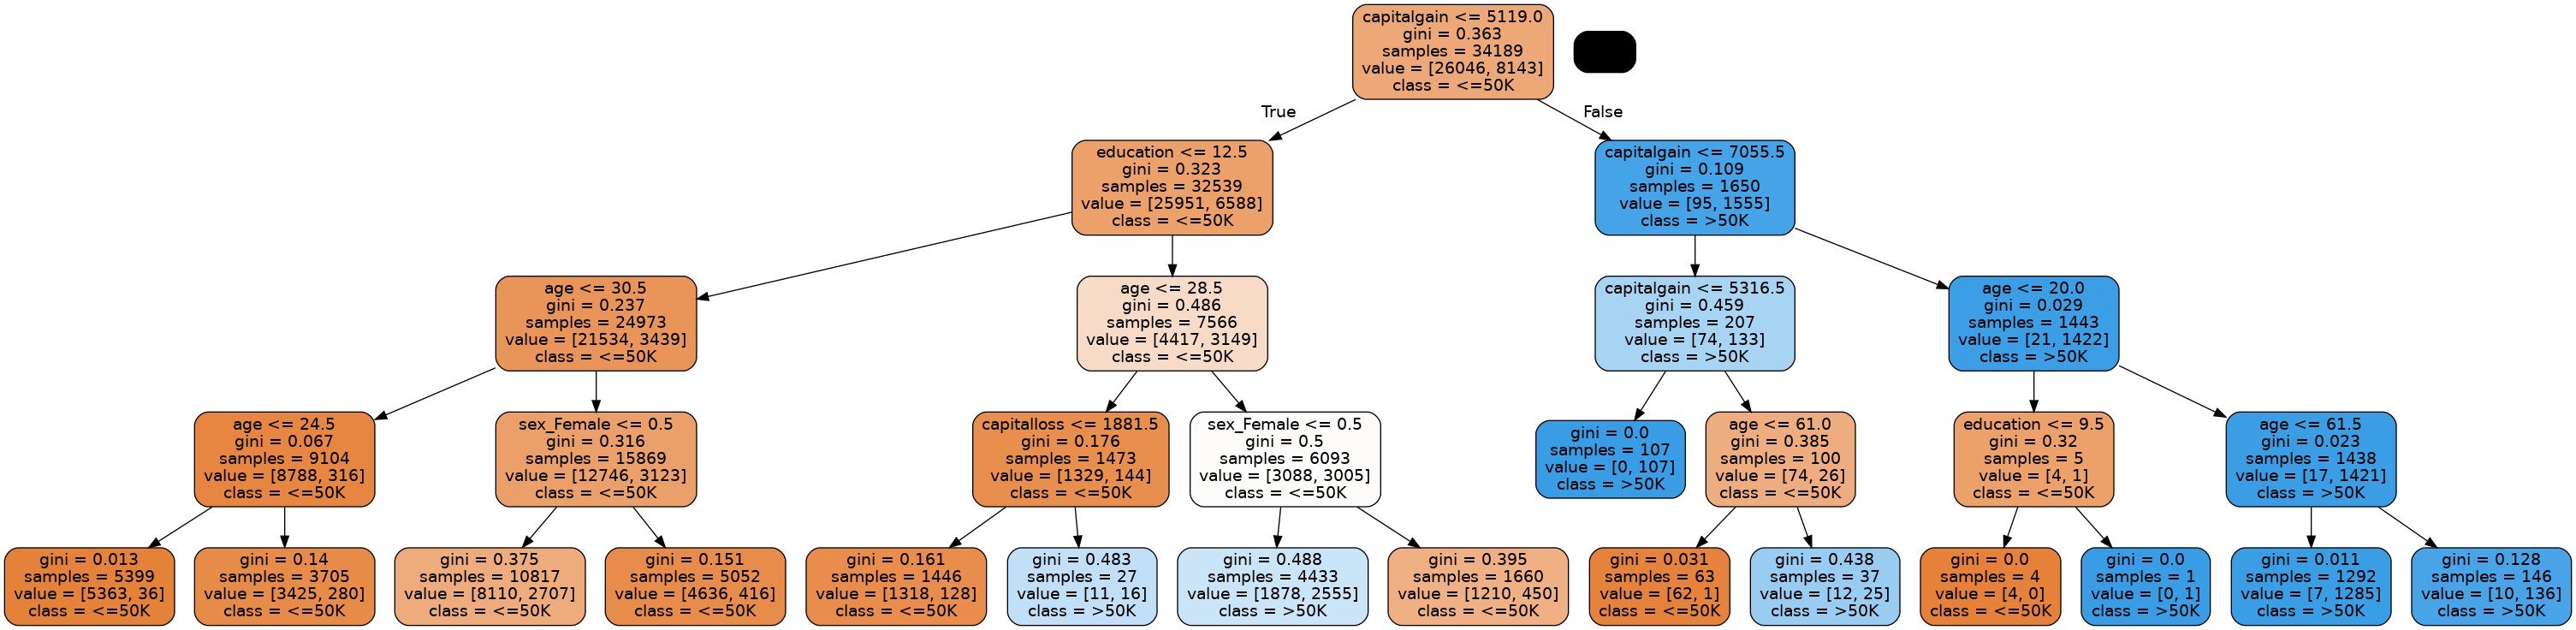

In [24]:
# visualize the decision tree
dot_data = tree.export_graphviz(clf1, out_file=None, 
                                feature_names=encoded_pred_atts, # attributes names
                                class_names=df_code.decode[target], # class labels
                                filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

### Experiment

In [26]:
# Model2CLP
r = reasonx.ReasonX(pred_atts, target, df_code, verbose=0)
r.model(clf1)

In [27]:
r.instance('F0', features=XT1.iloc[0:1], label=yt1.iloc[0])
r.instance('CE0', label=1-yt1.iloc[0])

print("LABEL", clf1.predict(XT1.iloc[0:1]))

constraints, n_ce, b, c, d, e = r.solveopt(minimize='l1norm(F0, CE0)', return_results = 1, evaluation=1, eps = 0.01)

print("Number of CEs ", n_ce)
print(b)

F0.race = White, F0.sex = Male, F0.workclass = Private, F0.education = HSgrad, F0.age = 18, F0.capitalgain = 0, F0.capitalloss = 0, F0.hoursperweek = 20
LABEL [0]
Number of CEs  7.0
[0.698601928374656, 0.4106392694063927, 0.05119061190611918, 0.6423437138480975, 0.13722247222472228, 0.09809005213339816, 0.6665832028183295]


In [28]:
# STEP 1: select CE based on minimal distance

index = b.index(min(b))
ce_constraints_min_dist = constraints[index][1]

d0 = min(b)
alpha_ = 1 / (2 * d0)

index_list = [index]

# STEP 2: enforce CE and initialize additional CE

r.constraint(ce_constraints_min_dist)
print(index, ce_constraints_min_dist, b[index])

# STEP 3: compute function values for two, three,... CEs

setsize = 3

for j in range(setsize - 1):
    # initialize new CE
    new_ce_name = "CE" + str(j + 1)
    r.instance(new_ce_name, label=1-yt1.iloc[0])
    
    # list of CE as string, to be extended during each iteration
    base = j + 2
    ce_names = "["
    for k in range(base):
        ce_names = ce_names + "CE" + str(k) + ", "
    ce_names = ce_names[:-2] + "]"
    print(new_ce_name, ce_names)

    function_values = []
    ind = []
    function_values_1 = []
    function_values_2 = []

    for i in range(int(n_ce)):
        # skip CEs that are already chosen
        if i in index_list:
            print(i)
            continue
        else:
            print("CONTRASTIVE INSTANCE ", i)
            # replace name of CE
            constraints_ = constraints[i][1].replace("CE0", new_ce_name)
            r.constraint(constraints_)
            # compute function values
            # term 1 (distance)
            term1 = "l1norm(F0, " + ce_names + ")"
            print(term1)
            function_1 = r.solveopt(minimize=term1, evaluation=None, diversity=1, eps = 0.01)
            function_values_1.append(function_1[0])
            # term 2 (proximity)
            function_2_ = 0
            for l in range(base):
                term2 = "l1norm(CE" + str(l) + ", " + ce_names + ")"
                print(term2)
                function_2_update = r.solveopt(minimize=term2, evaluation=None, diversity=1, eps = 0.01)
                function_2_ = function_2_ + function_2_update[0]
                
            function_values_2.append(function_2_)

            r.retract(constraints_)
            # weighted sum
            function_values.append((((float(alpha_/base) * function_1[0]) - (float(1 /(base * base)) * function_2_))))
            ind.append(i)
            print("VALUES", function_1, function_2_)

    # minimum (new CE)
    function_values_index = function_values.index(min(function_values))
    ce_constraints_min_dist = constraints[ind[function_values_index]][1]
    print(ind[function_values_index], function_values_index, ce_constraints_min_dist, function_values[function_values_index])

    # add original index (CE in the list of admissible sets) to index_list to avoid re-computing over it
    # this is also the results: index position of the subset of CEs
    index_list.append(ind[function_values_index])

    # add the new CE to the store
    r.constraint(ce_constraints_min_dist.replace("CE0", new_ce_name))

2 CE0.race=White,CE0.sex=Male,CE0.workclass=Private,CE0.education=9.0,CE0.age=18.0,CE0.capitalgain=5119.010000000012,CE0.capitalloss=0.0,CE0.hoursperweek=20.0 0.05119061190611918
CE1 [CE0, CE1]
CONTRASTIVE INSTANCE  0
l1norm(F0, [CE0, CE1])
l1norm(CE0, [CE0, CE1])
l1norm(CE1, [CE0, CE1])
VALUES [0.749792540280775] 1.4995850805615503
CONTRASTIVE INSTANCE  1
l1norm(F0, [CE0, CE1])
l1norm(CE0, [CE0, CE1])
l1norm(CE1, [CE0, CE1])
VALUES [0.4618298813125119] 0.9236597626250238
2
CONTRASTIVE INSTANCE  3
l1norm(F0, [CE0, CE1])
l1norm(CE0, [CE0, CE1])
l1norm(CE1, [CE0, CE1])
VALUES [0.6935343257542167] 1.1823062038839567
CONTRASTIVE INSTANCE  4
l1norm(F0, [CE0, CE1])
l1norm(CE0, [CE0, CE1])
l1norm(CE1, [CE0, CE1])
VALUES [0.1884130841308414] 0.17206372063720615
CONTRASTIVE INSTANCE  5
l1norm(F0, [CE0, CE1])
l1norm(CE0, [CE0, CE1])
l1norm(CE1, [CE0, CE1])
VALUES [0.14928066403951734] 0.09379888045455798
CONTRASTIVE INSTANCE  6
l1norm(F0, [CE0, CE1])
l1norm(CE0, [CE0, CE1])
l1norm(CE1, [CE0, CE1